In [1]:
from Utils import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pickle
import time
import cv2
import numpy as np
from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA

In [2]:
data_set, Y = readDataSet()

In [3]:
X_train, X_testValid, Y_train, Y_testValid = train_test_split(data_set, Y, test_size=0.2, random_state=60)  

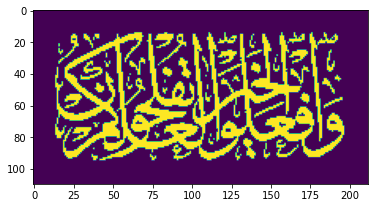

In [4]:
# visulaize dataset after training
import matplotlib.pyplot as plt
from random import seed
from random import randint
# seed random number generator
i = randint(0, len(X_train) -1)
plt.imshow(X_train[i])

In [5]:
# some constants
subset_size = 40000
no_clusters = 512

In [6]:
def getDescriptors(img):
    sift = sift = cv2.SIFT_create(100)
    kp, des = sift.detectAndCompute(img, None)
    return des

In [7]:
def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    return descriptors

In [8]:
def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

In [9]:
def generate_codebook(subset_size=40000, no_clusters=1024):
    descriptor_list = []
    image_count = len(X_train)
    for img in X_train:
        des = np.array(getDescriptors(img))
        if len(descriptor_list) == 0 :
            descriptors = des
        else:
            descriptors = np.vstack((descriptors, des))
        descriptor_list.append(des)
        
#     descriptors = vstackDescriptors(descriptor_list)
    print("descriptors shape before selecting a subset : ", descriptors.shape)
    # select a number of descriptors at random to train the KMeans classifier to get the codes
    number_of_rows = descriptors.shape[0]
    random_indices = np.random.choice(number_of_rows, size=subset_size, replace=False)
    descriptors = descriptors[random_indices, :]
    # reduce the dimensionality of the selected keypoints using pca
#     pca = PCA(n_components=64)
#     descriptors = pca.fit_transform(descriptors)
    print("descriptors shape after selecting a subset and applyting PCA : ", descriptors.shape)
    codes = clusterDescriptors(descriptors, no_clusters)
    return codes, descriptor_list
    

In [10]:
codes, dlist  = generate_codebook(subset_size, no_clusters)


descriptors shape before selecting a subset :  (128059, 128)
descriptors shape after selecting a subset and applyting PCA :  (40000, 128)


In [11]:
# Extract features
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1
            
    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("images normalized.")

    return im_features

In [12]:
im_features = extractFeatures(codes, dlist, len(X_train), no_clusters)

images normalized.


In [13]:
# get descriptors for test set
dlist_test = []
for img in X_testValid:
    des = getDescriptors(img)
    dlist_test.append(des)
im_features_test = extractFeatures(codes, dlist_test, len(X_testValid), no_clusters)
print(im_features_test.shape)

images normalized.
(337, 512)


In [14]:
# # apply KNN
# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=5)
# neigh.fit(im_features, Y_train)

# # testing
# answers = []
# y_pred = neigh.predict(im_features_test)

In [15]:
X = np.array(im_features)
y = np.array(Y_train)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
# predict the test data
y_pred = (clf.predict(im_features_test))

In [16]:
# calculate accuracy
acc = np.mean(y_pred == Y_testValid) * 100
print(acc, "%")

97.03264094955489 %


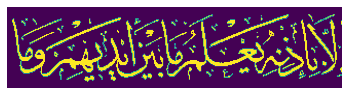

Actual class : thuluth
predicted_class :  mohakek
---------------------------------------


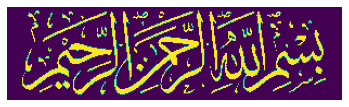

Actual class : thuluth
predicted_class :  mohakek
---------------------------------------


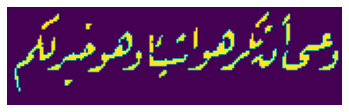

Actual class : rekaa
predicted_class :  parsi
---------------------------------------


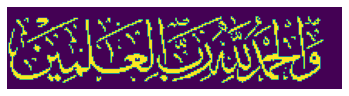

Actual class : thuluth
predicted_class :  mohakek
---------------------------------------


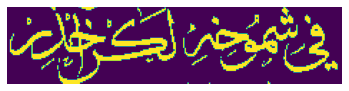

Actual class : thuluth
predicted_class :  mohakek
---------------------------------------


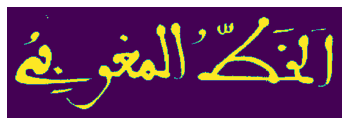

Actual class : maghribi
predicted_class :  kufi
---------------------------------------


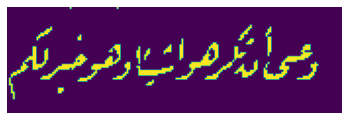

Actual class : rekaa
predicted_class :  parsi
---------------------------------------


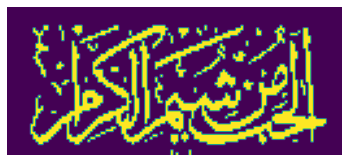

Actual class : thuluth
predicted_class :  mohakek
---------------------------------------


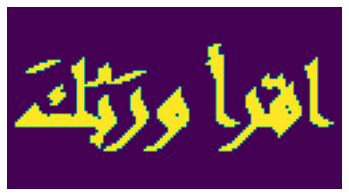

Actual class : kufi
predicted_class :  maghribi
---------------------------------------


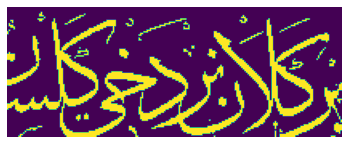

Actual class : thuluth
predicted_class :  rekaa
---------------------------------------


In [17]:
classes = ["diwani", "naskh", "parsi", "rekaa", "thuluth", "maghribi", "kufi", "mohakek", "Squar-kufic"]

# show wrongly classified examples
for i in range(len(X_testValid)):
    if(y_pred[i] != Y_testValid[i]):
        # Visualize each test figure. 
        fig = plt.figure()
        plt.imshow(X_testValid[i])
        plt.axis("off")
        plt.show()

        # Print the actual class of each test figure. 
        print("Actual class :", classes[Y_testValid[i]])
        print("predicted_class : ", classes[y_pred[i]])
        print("---------------------------------------")